## Importing libraries

In [1]:
import sklearn.tree as tree
import pandas as pd
from hazm import Stemmer ,Lemmatizer
import multiprocessing.pool as pool
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dis

## Open CorpusText & StopWords 

In [4]:

a1 = pd.read_csv('./DataSets/EconomyCleaned.csv',index_col='Unnamed: 0')
a2 = pd.read_csv('./DataSets/PoliticCleaned.csv',index_col='Unnamed: 0')
a3 = pd.read_csv('./DataSets/SocialCleaned.csv',index_col='Unnamed: 0')
# a3 = pd.read_csv('./DataSets/S',index_col='Unnamed: 0')
# corpus_original = pd.read_csv('./DataSets/EconomyCleaned.csv',index_col='Unnamed: 0')
corpus_original = a1.append(a2).append(a3)

corpus = corpus_original.copy()
stopWords = pd.read_csv('./stopWords.txt', sep='\t',header=None)
stopWords = list(stopWords[0])
stopWords.append('تر')
stopWords.append('ترین')
stopWords.append('ها')
stopWords.append('های')
stopWords.append('ای')
stopWords.append('\r')
stopWords.append('ی')
stopWords.append('خواهد')
stopWords.append('ااب')
stopWords.append('-')


# stopWords.head()
# corpus.head()

## Get text data 

In [5]:
corpus = corpus.drop(['date'],axis=1)
corpus = corpus[['title','summery','body','cat','subcat']]
corpus = corpus[corpus['cat'].isin(['اجتماعی','اقتصادی' , 'سیاسی'])]

In [6]:
corpus.groupby(['cat']).count()

,title,summery,body,subcat
cat,,,,
اجتماعی,1915,1915,1915,1915
اقتصادی,2204,2204,2204,2204
سیاسی,2520,2520,2520,2520


## Let's Start

We want model our document to vector

We find 100 important words from our corpus

at first we set weight:
- words in title: 3x 
- words in summary: 2x 
- words in body: 1x 

### 1- set vector dimention

some cleaninc in text for some chars: '\n' , ':' , '.' , ',' and ...

In [7]:
# corpus = corpus_original.copy()
def clean(text):
    text = text.replace('\n',' ').\
                replace(':','').\
                replace('.','').\
                replace('،','').\
                replace('/','').\
                replace('فیلم','').\
                replace('+','').\
                replace('»','').\
                replace('«','').\
                replace('(','').\
                replace(')','').\
                replace('\xa0','').\
                replace('\u200c',' ')
    
    text = text.replace('گزارش','').\
                replace('فارس','').\
                replace('نقل','').\
                replace('خبرگزاری','').\
                replace('خبرنگار','')
    
    
    text = text.replace('  ',' ')
    t = text.split(' ')
    t = [x for x in t if x not in stopWords and\
                           not x.isdigit() and\
                           not '']
    return t

corpus['title']   = corpus['title'].apply(clean)
corpus['summery'] = corpus['summery'].apply(clean)
corpus['body']    = corpus['body'].apply(clean)


In [8]:
dictionary = {'ahmad':12}

#inner function
stem = lambda x:Stemmer().stem(x)
lem = lambda x:Lemmatizer().lemmatize(x)
def cbow_adder(x,importance=1):
#     print('      ',x,x in dictionary.keys())
    if x in dictionary.keys():
#         print('      ',dictionary)
        dictionary[x] += 1*importance
    else:
        
        dictionary[x] = 1*importance
    return x

#outter function
cbow_maker     = lambda txt: (list(map(cbow_adder,txt)))
# cbow_stemmer   = lambda txt: (list(map(stem,txt)))
# cbow_lemmatize = lambda txt: (list(map(lem,txt)))
# def cbow_maker(txt):
#     print('     ',dictionary)
#     return (list(map(cbow_adder,txt)))

# def cbow_stemmer(txt):
#     return (list(map(stem,txt)))

# def cbow_lemmatize(txt):
#     return (list(map(lem,txt)))

# p = pool.Pool(5)
#start function
# corpus.title   = corpus.title.apply(cbow_lemmatize)
# corpus.title = p.map(cbow_maker , corpus.title)
# with pool.Pool(5) as p:
# #         corpus.title =
#     p.imap(cbow_maker , corpus.title[:100])
map(cbow_maker , corpus.title[:100])
#     print('    ',dictionary)
# print('       ','lemma done!')

# with pool.Pool(5) as p:
#         p.map(cbow_stemmer,corpus.summery)
# corpus.title   = corpus.title.apply(cbow_stemmer)
# corpus.title   = p.map(cbow_stemmer)
# print('       ','stm done!')
corpus.title   = corpus.title.apply(cbow_maker)
# corpus.title   = p.map(cbow_maker)
# with pool.Pool(5) as p:
#         p.map(cbow_maker,corpus.body)
# print('       ','maker done!')

dictionary = {k:v*1.5 for k, v in dictionary.items()}

# corpus.summery   = corpus.summery.apply(cbow_lemmatize)
# corpus.summery   = corpus.summery.apply(cbow_stemmer)
corpus.summery   = corpus.summery.apply(cbow_maker)
dictionary = {k:v*2 for k, v in dictionary.items()}

# corpus.body   = corpus.body.apply(cbow_lemmatize)
# corpus.body   = corpus.body.apply(cbow_stemmer)
corpus.body   = corpus.body.apply(cbow_maker)
# print(dictionary)

In [9]:
def dimFinder(corpus,dimNum=100):
    dictionary = {'ahmad':12}

    #inner function
    stem = lambda x:Stemmer().stem(x)
    lem = lambda x:Lemmatizer().lemmatize(x)
    def cbow_adder(x,importance=1):
        if x in dictionary.keys():
            dictionary[x] += 1*importance
        else:

            dictionary[x] = 1*importance
        return x

    cbow_maker     = lambda txt: (list(map(cbow_adder,txt)))
    map(cbow_maker , corpus.title[:100])
    corpus.title   = corpus.title.apply(cbow_maker)

    dictionary = {k:v*1.5 for k, v in dictionary.items()}

    corpus.summery   = corpus.summery.apply(cbow_maker)
    dictionary = {k:v*2 for k, v in dictionary.items()}

    corpus.body   = corpus.body.apply(cbow_maker)
#     dictionary
    di = {
        'word':[*dictionary],
        'frequency':list(dictionary.values())
    }
    cbow = pd.DataFrame.from_dict(di)

    cbow = cbow.sort_values(by='frequency',ascending=False)
    cbow = cbow[cbow.word != '']
    dims = cbow[:dimNum]
    return(dims)

In [10]:
dictionary
di = {
    'word':[*dictionary],
    'frequency':list(dictionary.values())
}
cbow = pd.DataFrame.from_dict(di)

cbow = cbow.sort_values(by='frequency',ascending=False)
cbow = cbow[cbow.word != '']
dims = cbow[:100]
dims[50:100]


,word,frequency
771,استفاده,4303.0
118,بانک,4303.0
2316,توجه,4285.0
399,اقتصاد,4270.0
1575,موضوع,4099.0
727,ایجاد,4059.0
2484,شهر,4055.0
248,میلیون,4006.0
333,تومان,3995.0
526,استان,3950.0


In [11]:
dim1 = dimFinder(corpus[corpus.cat=='اجتماعی'])
dim2 = dimFinder(corpus[corpus.cat=='اقتصادی'])
dim3 = dimFinder(corpus[corpus.cat=='سیاسی'])
dimAll = dimFinder(corpus)


/home/ahmad/myenv/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [12]:
frequentWord = (set(dim1['word'])&(set(dim2['word']))&(set(dim3['word'])))
d = dimAll.word
f = dimAll[d.isin(list(frequentWord))]
# f.shape[0]

In [13]:
dimAll = dimFinder(corpus=corpus,dimNum=100+f.shape[0])
dimAll = dimAll[~dimAll.word.isin(list(frequentWord))]
# dimAll.shape
dimAll

,word,frequency
1665,اسلامی,10936.0
35,آمریکا,9219.0
97,نفت,7476.0
36,قیمت,6904.0
166,افزایش,6842.0
105,شرکت,6787.0
84,هزار,6422.0
282,تحریم,5536.0
87,بازار,5187.0
41,درصد,5164.0


In [14]:
# _max = dimAll.frequency.max()
# dimAll.frequency = dimAll.frequency/_max
# cbow[:200].frequency.plot.bar(by='frequency',figsize=(25,10))
# plt.show()
# dimAll

In [15]:
vector_element = np.array(dimAll.word)
vectors_weight = np.array(dimAll.frequency)
# type(dims.frequency[18])


In [16]:

vector_dict = [(i[1].word,i[1].frequency) for i in dims.iterrows() ]
vector_dict = dict(vector_dict)


In [17]:
import sklearn as sk


## Learn vector for NEWS

In [18]:

corpus['corpusAll'] = corpus.title*3 + corpus.summery*2 + corpus.body
# corpus['corpusAll']

In [385]:

def vectorComputer(doc):
    points = []
    for word in dimAll.iterrows():
        points = [doc.count(i) for i in dimAll.word]
        
    return(points)
vectors = pd.DataFrame(list(map(vectorComputer,corpus.corpusAll)))
# idf(corpusAll[2500])
# 2/pd.DataFrame([12,12])
vectors.to_csv('./DataSets/Vectors.csv')

## TF-IDF

- TF  = freq(word)/len(doc)
- -
- IDF = (NumberOfDoc)/(NumberOfDocHasThisWord)
- -
- w = TF * IDF

In [216]:
vectors = pd.read_csv('./DataSets/Vectors.csv',index_col='Unnamed: 0')
idf = np.log(corpus.shape[0]/\
             pd.DataFrame([vectors[vectors[i]!=0].shape[0] for i in list(vectors.columns)]))

idf =  pd.Series(list(idf[0]))
# for i in range(vectors.shape[0]):
# vectorUpdated = pd.DataFrame()
for i in range(vectors.shape[0]):
    tf = vectors.iloc[i] / len(corpus.corpusAll.iloc[i])
    tf = pd.Series(list(tf))
    vectors.iloc[i] = list(idf * pd.Series(list(tf)))
vectors.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.00000,0.000000,0.0,0.00000,0.025716,0.000000,0.0,0.0,0.000000,0.010716,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.016797,0.000000,0.0,0.0
1,0.00000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.009903,0.0,0.0,0.0,0.0,0.000000,0.008195,0.0,0.0
2,0.00247,0.000000,0.0,0.00903,0.009948,0.000000,0.0,0.0,0.018942,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.00000,0.000000,0.0,0.00000,0.009870,0.000000,0.0,0.0,0.000000,0.008226,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.006447,0.000000,0.0,0.0
4,0.00000,0.035322,0.0,0.00000,0.000000,0.030699,0.0,0.0,0.000000,0.000000,...,0.0,0.018288,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
from sklearn import svm

In [339]:
d = []
for i in vectors.iloc[:].iterrows():
#     g = 
#     print(list(i))list(i[1])
    d.append(list(i[1]))
# type(g)
# np.array(g)
# len(d[0])

In [347]:
len(d)
len(corpus.cat.tolist())
tmp = corpus.cat
def l(x):
    if x == 'اقتصادی':
        return 1
    elif x == 'اجتماعی':
        return 2
    elif x == 'سیاسی':
        return 3
    
lable = tmp.apply(l)
# lable = np.array(lable)
# d = np.array(d)

In [391]:
clf = svm.SVC()
clf.fit(d,lable)
# clf.fit(np.array([[1],[2],[3]]),np.array([1,2,3]))
# len(lable[1:3])
# len(d[1:3])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [397]:
list(clf.predict(X=d)).count(1)


0

In [386]:
lable

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
1820    2
1821    2
1822    2
1823    2
1824    2
1825    2
1826    2
1827    2
1828    2
1829    2
1830    2
1831    2
1832    2
1833    2
1834    2
1835    2
1836    2
1837    2
1838    2
1839    2
1840    2
1841    2
1842    2
1843    2
1844    2
1845    2
1846    2
1847    2
1848    2
1849    2
Name: cat, Length: 6639, dtype: int64

In [ ]:
vec_spc = []
def vecCalculate():
    

In [360]:

vec_spc = []
for txt in corpus.iterrows():
    txt = txt[1]
    tmp_body  = [txt.body.count(i) for i in dims.word]
    tmp_title = [txt.title.count(i) for i in dims.word]
    tmp_summ  = [txt.summery.count(i) for i in dims.word]
    f = [tmp_body[i] + tmp_summ[i]*2 + tmp_title[i]*3 for i in range(len(tmp_body))]
    vec_spc.append(f)


In [361]:
v = pd.DataFrame(vec_spc)
t = v[:100]


In [362]:
d = []
tmp = []
for i in t.iterrows():
    tmp = []
    for j in t.iterrows():
        tmp.append(dis.cosine(j[1],i[1]))
    d.append(tmp)
r = np.array(r)
r[r==0] = 1

In [375]:
np.where(r<.36)
# r.min()

(array([ 6, 10, 16, 20, 24, 24, 32, 32, 37, 42]),
 array([16, 20,  6, 10, 32, 37, 24, 42, 24, 32]))

In [132]:
corpus_original.head()

,body,cat,date,subcat,summery,teller,time,title
0,\nبه گزارش خبرگزاری فارس به نقل از کنفدراسیون ...,اقتصادی,۱۳۹۷/۷/۱,\r\nصنعت ، تجارت ، بازرگانی\r\n,\r\nبر اساس تصمیم وزیر صنعت،‌معدن و تجارت مدت ...,بر اساس تصمیم وزیر صنعت،‌معدن و تجارت,۱۸:۴۸,مدت زمان بازگشت ارز حاصل از صادرات فرش 7 ماهه شد
1,\nبه گزارش خبرگزاری فارس به نقل از روابط عمومی...,اقتصادی,۱۳۹۷/۷/۱,\r\nصنعت ، تجارت ، بازرگانی\r\n,\r\nمرکز توسعه تجارت الکترونیکی با صدور اطلاعی...,از سوی مرکز توسعه تجارت الکترونیکی منتشر شد,۱۸:۰۹,اطلاعیه‌ دیرهنگام مبنی برغیرقانونی بودن فعالیت...
2,\nبه گزارش خبرنگار اقتصادی خبرگزاری فارس، در ح...,اقتصادی,۱۳۹۷/۷/۱,\r\nصنعت ، تجارت ، بازرگانی\r\n,\r\nدر حالی که قرار بوددر هفته جاریاستیضاح شری...,فارس گزارش می‌دهد,۱۷:۳۳,دو راهی استیضاح و استعفای شریعتمداری
3,\nبه گزارش خبرنگار اقتصادی خبرگزاری فارس، براس...,اقتصادی,۱۳۹۷/۷/۱,\r\nراه و مسکن\r\n,\r\nآسمان تهران فردا نیمه‌ابری در برخی ساعات ر...,فارس از وضعیت آب‌‌و‌‌هوا گزارش می‌دهد,۱۷:۱۵,وزش باد شدید و رعدوبرق در پایتخت/هشدار وقوع سی...
4,\nبه گزارش خبرگزاری فارس به نقل از انگجت، گوگل...,اقتصادی,۱۳۹۷/۷/۱,\r\nارتباطات و فن آوری اطلاعات\r\n,\r\nکاربران گوشی‌های پیکسل گوگل که به دنبال وق...,NaN,۱۷:۱۲,تعمیر رایگان گوشی‌های آسیب‌دیده در توفان سهمگی...


In [372]:

h = np.where(r==r.min())[0]
corpus_original.iloc[h]

,whoTell,title,summery,body,date,day,time,year,month
10,معاون وزیر انرژی روسیه:,روسیه قادر نیست کمبود انرژی بازار آسیایی در اث...,معاون وزیر انرژی روسیه گفت: روسیه واقعا قادر ن...,\nبه گزارش گروه اقتصاد بین‌الملل خبرگزاری فارس...,1397/07/10 :: 17:01,10,17,1397,7
20,یک کارشناس نفتی اعلام کرد,پیشتازی نفت به سمت 100 دلار/عربستان نتوانست خو...,یک کارشناس نفتی گفت: احتمال زیاد قمیت نفت برای...,\nبه گزارش خبرنگار اقتصاد بین‌الملل خبرگزاری ف...,1397/07/10 :: 14:52,10,14,1397,7


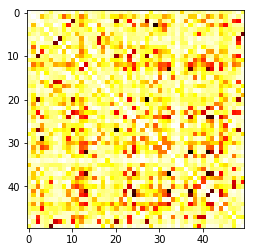

In [309]:
plt.imshow(r, cmap='hot', interpolation='nearest')
plt.show()
